### distribution functions

In [1]:
from numpy import pi as PI

import scipy
import numpy as np

# =============================================================================
#  ---------------- (DIS-)SIMILARITY DISTRIBUTION FUNCTIONS ------------------
# =============================================================================
def pdf_distance(t, kappa):
    """
    Cumulative distribution function of (circular) distance of two wrapped
    exponentialy distributed random variables with scale parameter kappa.
    Support is on [0,1].
    """
    support = np.where((0<t) & (t<PI), 1., 0.)
    return support * kappa/np.sinh(PI*kappa) * np.cosh((PI-t)*kappa)

def cdf_distance(t, kappa):
    """
    Cumulative distribution function of (circular) distance of two wrapped
    exponentialy distributed random variables with scale parameter kappa.
    F(t)=0 for t<0 and F(t)=1 for t>pi.
    """
    support = np.where(0<=t, 1., 0.)
    values = 1 - np.sinh((PI-t)*kappa) / np.sinh(PI*kappa)
    return support * np.where(t>=PI,1,values)

def pdf_similarity(t, kappa, a):
    """
    (Continuous part of the) probability density function of s_a ∘ d(X,Y), 
    where X,Y are two wrapped exponentially distributed random variables 
    with scale parameter 1/kappa, d(-,-) denotes the distance on the circle 
    and s_a(-) is the area of the (normalized) overlap of two boxes of length 
    2*pi*a on the circle for a given distance (measured from edge to edge, 
    or equivalently from center to center). 
    Normalization is taken to be the area of one box, 2*pi*a. Hence, the 
    support is on [s_min,pi], where s_min=|2-1/a|^+.
    """
    s_min = np.clip(2-1/a,0,1)
    support = np.where((s_min<=t) & (t<=1), 1., 0.)
    return support * 2*a*PI*pdf_distance(2*a*PI*(1-t), kappa)

def cdf_similarity(t, kappa, a):
    """
    Cumulative distribution function of s_a ∘ d(X,Y), where X,Y are two wrapped
    exponentially distributed random variables with scale parameter 1/kappa,
    d(-,-) denotes the distance on the circle and s_a(-) is the area of the
    (normalized) overlap of two boxes of length 2*pi*a on the circle for a
    given distance (measured from edge to edge, or equivalently from center 
    to center). 
    Normalization is taken to be the area of one box, 2*pi*a. Hence, the 
    support is on [s_min,pi], where s_min=|2-1/a|^+.
    """
    s_min = np.clip(2-1/a,0,1)
    support = np.where(s_min<=t, 1., 0.)
    values = 1 - cdf_distance(2*a*PI*(1-t), kappa=kappa)
    return support * np.where(t>=1, 1., values)

def mean_similarity(kappa, a):
    numer = 2*np.sinh(PI*kappa)*np.sinh((1-a)*PI*kappa)*np.sinh(a*PI*kappa)
    denom = a*PI*kappa*(np.cosh(2*PI*kappa)-1)
    return 1 - numer/denom

### network_model

In [2]:
from ringity.distribution_functions import mean_similarity
from scipy.spatial.distance import pdist, squareform
from numpy import pi as PI

import scipy
import numpy as np
import networkx as nx

# =============================================================================
#  -------------------------------  PREPARATION -----------------------------
# =============================================================================
def get_positions(N, beta):
    if   beta == 0:
        return np.zeros(N)
    elif beta == 1:
        return np.random.uniform(0,2*PI, size=N)
    else:
        return np.random.exponential(scale=1/np.tan(PI*(1-beta)/2), size=N) % (2*PI)


def geodesic_distances(thetas):
    abs_dists = pdist(thetas.reshape(-1,1))
    return np.where(abs_dists<PI, abs_dists, 2*PI-abs_dists)


def overlap(dist, a):
    """
    Calculates the overlap of two boxes of length 2*pi*a on the circle for a
    given distance dist (measured from center to center).
    """

    x1 = (2*PI*a-dist).clip(0)
    if a <= 0.5:
        return x1
    # for box sizesw with a>0 there is a second overlap
    else:
        x2 = (dist-2*PI*(1-a)).clip(0)
        return x1 + x2

def slope(rho, kappa, a):
    mu_S = mean_similarity(kappa,a)
    if rho <= mu_S:
        return rho/mu_S
    else:
        const = 1/np.sinh(PI*kappa)
        def integral(k): # This can probably be further simplified
            term1 = np.sinh((1 + 2*a*(1/k-1))*PI*kappa)
            term2 = (k*np.sinh((a*PI*kappa)/k)*np.sinh(((a+k-2*a*k)*PI*kappa)/k))/(a*PI*kappa)
            return term1-term2
        return scipy.optimize.newton(
            func = lambda k: const*integral(k) + (1-cdf_similarity(1/k, kappa, a)) - rho,
            x0 = rho/mu_S)

# =============================================================================
#  ------------------------------  NETWORK MODEL ----------------------------
# =============================================================================

def weighted_network_model(N, rho, beta, a=0.5, return_positions=False):
    """
    Returns samples of the Network model as described in [1]
    The outputs are samples of the
     - positions of the nodes placed on the circle according to a
       (wrapped) exponential distribution,
     - their pairwise distances
     - their similarities, given an 'activity window' of size a
     - their connection probabilities, given the expected density rho.
    """

    # just maiking sure no one tries to be funny...

    assert 0 <= beta <= 1
    assert 0 <   a   <= 1
    assert 0 <= rho  <= 1

    if beta == 0 or a == 1:
        posis = np.zeros(N)
        simis = np.ones(int(N*(N-1)/2))
        k = rho
    elif beta == 1:
        assert rho < 2*a, "Please increase `a` or decrease `rho`!"
        posis = np.random.uniform(0,2*PI, size=N)
        dists = geodesic_distances(posis)
        simis = overlap(dists, a)/(2*PI*a)

        if rho <= a:
            k = rho/a
        else:
            k = a/(2*a-rho)
    else:
        kappa = np.tan(PI*(1-beta)/2)
        assert rho < 1-np.sinh((PI-2*a*PI)*kappa) / np.sinh(PI*kappa), "Please increase `a` or decrease `rho`!"
        posis = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
        dists = geodesic_distances(posis)
        simis = overlap(dists, a)/(2*PI*a)
        k = slope(rho, kappa, a)

    probs = (simis*k).clip(0,1)
    if return_positions:
        return posis, probs
    else:
        return probs


def network_model(N, rho, beta, a=0.5, return_positions=False):
    """
    Network model as described in [1]. The output is the (empirical) positions
    of the nodes placed on the circle according to a von Mises distribution,
    followed by a tripple consisting of the (empirical) distribution of the
    pairwise distances, similarities and connection probabilities respectively.
    """
    if return_positions:
        posis, probs = weighted_network_model(N = N,
                                              rho = rho,
                                              beta = beta,
                                              a = a,
                                              return_positions = True)
    else:
        probs = weighted_network_model(N = N,
                                       rho = rho,
                                       beta = beta,
                                       a = a,
                                       return_positions = False)

    rands = np.random.uniform(size=int(N*(N-1)/2))
    A = squareform(np.where(probs>rands, 1, 0))
    G = nx.from_numpy_array(A)

    if return_positions:
        return posis, G
    else:
        return G

# =============================================================================
#  ------------------------------ REFERENCES ---------------------------------
# =============================================================================

# [1] Not published yet.

## Here we go

In [3]:
from itertools import combinations
from scipy.integrate import quad

import numpy as np
import matplotlib.pyplot as plt

In [38]:
N = 2**13
rho = 0.812
beta = 0.1
a = 0.8
kappa = np.tan(PI*(1-beta)/2)

posis = get_positions(N, beta)
dists = geodesic_distances(posis)
simis = overlap(dists, a)/(2*PI*a)

In [39]:
np.mean((simis*slope(rho, kappa, a)).clip(0,1))

0.8117288265759068

In [28]:
a/(2*a-rho)

(0.7356767722891764, 0.7344956492393723)

(-0.05, 1.05)

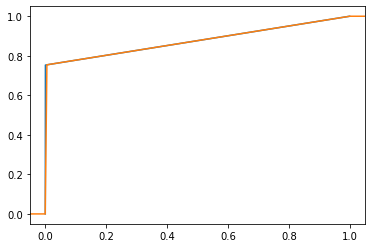

In [40]:
x1 = np.sort(simis)
y1 = np.linspace(0,1,len(simis))

x2 = np.linspace(-0.05,1.05,200)
y2 = cdf_similarity(x2, kappa, a)

plt.plot(x1,y1);
plt.plot(x2,y2);

ax = plt.gca()
ax.set_xlim(-0.05,1.05)

In [80]:
np.min(simis)

0.0

In [47]:
(2*a-1)/a

0.23633156966490285

In [51]:
x = np.linspace(1,0,100,endpoint=False)
y = (2-1/x).clip(0)

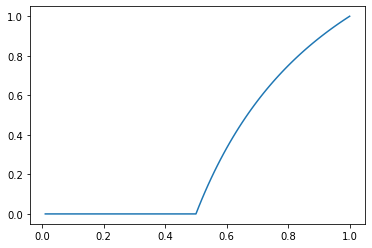

In [52]:
plt.plot(x,y)

In [51]:
rho = 0.175

np.mean((simis*(a/(2*a-rho))).clip(0,1))

0.17506554752326803

In [54]:
rho = 10

assert rho < 2*a, "Please increase `a` or decrease `rho`!"

AssertionError: Please increase `a` or decrease `rho`!

In [25]:
posis = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
dists = geodesic_distances(posis)
simis = overlap(dists, a)/(2*PI*a)
#probs = simis*slope(rho, a, kappa)

(0.0, 6.283185307179586)

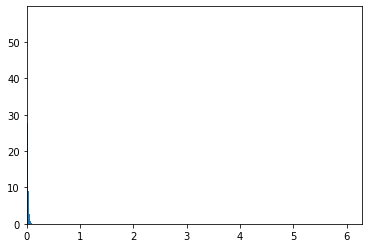

In [54]:
N = 2**16
beta = 0.01
kappa = np.tan(PI*(1-beta)/2)
posis = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
plt.hist(posis,bins=50, density=True);
ax = plt.gca()
ax.set_xlim(0,2*PI)
#plt.plot(x,y)

In [52]:
np.mean(posis)

0.01575585845026477

0.9999999999999999

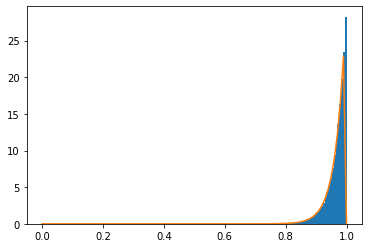

In [21]:
x = np.linspace(0,1,100)
y = pdf_similarity(x,kappa,a)

plt.hist(simis,bins=50, density=True);
plt.plot(x,y)

In [11]:
N = 2**10
G = network_model(N,rho,kappa=kappa,a=a)

In [12]:
nx.density(G), rho

(0.14829239980449657, 0.15)

In [13]:
N = 2**12
a = 0.3
kappa = 0.6

centers = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
dists = geodesic_distances(centers)
simis = overlap(dists, a)/(2*PI*a)

In [17]:
np.mean(simis), mu_similarity(kappa, a)

(0.4213724491397234, 0.4308098918007214)

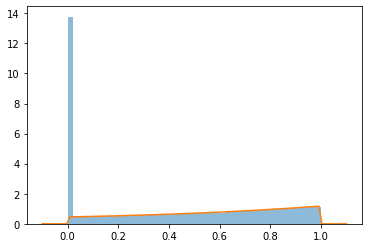

In [18]:
x = np.linspace(-0.1,1.1, 100)
f_X = kappa*np.exp(-kappa*x)/(1-np.exp(-2*PI*kappa))
f_D = pdf_similarity(x, kappa, a)

plt.hist(simis  , bins=50, alpha=0.50, density=True);
plt.plot(x, f_D)

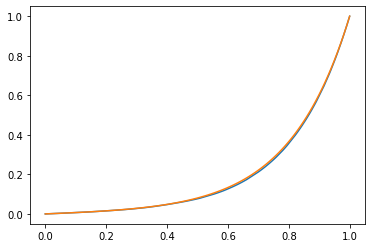

In [31]:
thetas = np.linspace(0,1,100)
x = np.sort(simis)
y = np.linspace(0,1,len(x))
plt.plot(x, y)
plt.plot(thetas, cdf_similarity(thetas, kappa, a))

In [15]:
1-cdf_distance(2*PI*a, kappa)

0.6677051249253559

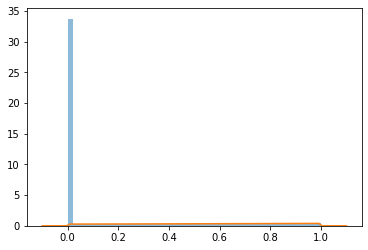

In [17]:
x = np.linspace(-0.1,1.1, 100)
f_X = kappa*np.exp(-kappa*x)/(1-np.exp(-2*PI*kappa))
f_D = pdf_similarity(x, kappa, a)

plt.hist(simis  , bins=50, alpha=0.50, density=True);
plt.plot(x, f_D)

In [4]:
from itertools import product

In [7]:
N = 2**9

for rho, beta, a in product(np.linspace(0.01,0.99,5),np.linspace(0,1,5), np.linspace(1,0,5,endpoint=False)):
    try:
        G = network_model(N,rho,beta,a)
    except AssertionError:
        continue
    dens = nx.density(G)
    if abs(dens-rho)>0.01:
        print(dens, rho)
        print(rho, a, beta)
        print()

0.24393805039138944 0.255
0.255 0.3999999999999999 0.5

0.4806522137964775 0.5
0.5 0.3999999999999999 0.75

0.7167930528375733 0.745
0.745 0.3999999999999999 0.5

0.7249342588062623 0.745
0.745 0.3999999999999999 0.75



In [13]:
rho, a, beta = 0.745, 0.3999999999999999, 0.75

np.mean([nx.density(network_model(N,rho,beta,a)) for _ in range(20)])

0.7477670927103717

### testing rng

In [12]:
from collections import Counter

import numpy as np
import ringity as rng
import matplotlib.pyplot as plt

In [100]:
N = 2**11
rho = 0.05
a = 0.1
beta = 0.5

G = rng.network_model(N, rho, beta, a)

In [101]:
deg_list = [deg for _,deg in G.degree]
degCount_obs = Counter(sorted(deg_list))
degs_obs, cnts_obs = zip(*degCount_obs.items())
cnts_obs = np.array(cnts_obs)

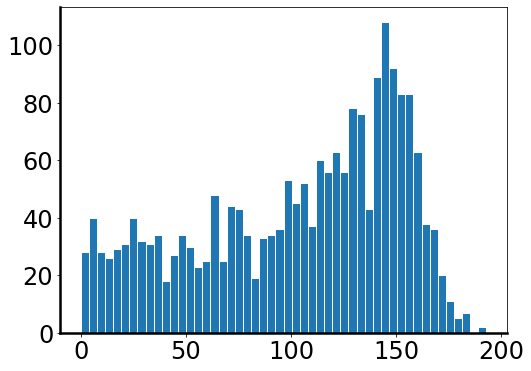

In [102]:
width = 1

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)

ax.hist(deg_list, bins=50, edgecolor='w');

rng.ax_setup(ax)

In [88]:
?ax.hist

In [89]:
? ax.bar